In [1]:
import os
import sys
import pandas as pd
from dotenv import load_dotenv 
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
project_root = Path(os.path.abspath('')).parent.parent
sys.path.append(str(project_root))

intermadiate_data_dir = project_root / 'intermediate_data'


load_dotenv()

NIH_CXR14_DATASET_DIR = os.getenv("NIH_CXR14_DATASET_DIR")
print(NIH_CXR14_DATASET_DIR)

device = "cuda:0"

/home/yasin/Lfstorage/datasets/nih-cxr14


In [2]:
from src.pipelines import InceptionProcessor

inception_processor = InceptionProcessor(device=device)


/home/yasin/Lfstorage/Projects/cxr-diffusion/.venv/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-03-08 23:15:34.567717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741464934.595415  747549 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741464934.604037  747549 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 23:15:34.634123: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.


In [3]:
generated_dir = "./generated_images"

generated_images = os.listdir(generated_dir)
generated_images = [os.path.join(generated_dir, img) for img in generated_images]

In [4]:
original_path = os.path.join(NIH_CXR14_DATASET_DIR, "original")

dirs = os.listdir(original_path)
dirs = [ os.path.join(original_path, dir) for dir in dirs if os.path.isdir(os.path.join(original_path, dir))]
filtered_images = pd.read_csv(intermadiate_data_dir / "filtered_findings_label_data.csv")["Image Index"].tolist()

paths = []
for dir in dirs:
    dir = os.path.join(dir, "images")
    files = os.listdir(dir)
    for file in files:
        if file in filtered_images:
            paths.append(os.path.join(dir, file))

original_images = paths
print(len(original_images), len(generated_images))



48311 48311


In [14]:
class customdataset(Dataset):
    def __init__(self, images_path, transform=None):
        self.images_path = images_path
        self.transform = transform
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, index):
        image = self.images_path[index]
        image = Image.open(image).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([transforms.Resize((299, 299)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])


In [15]:
batch_size = 512
num_workers = 24

In [16]:
dataset = customdataset(original_images, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

original_features = []
for i, data in enumerate(dataloader):
    data = data.to(device)
    feat = inception_processor(data)
    original_features.extend(feat)


In [17]:
dataset = customdataset(generated_images, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

generated_features = []
for i, data in enumerate(dataloader):
    data = data.to(device)
    feat = inception_processor(data)
    generated_features.extend(feat)

In [18]:
import numpy as np
np_original_features = np.array(original_features)
np_generated_features = np.array(generated_features)
print(np_original_features.shape, np_generated_features.shape)

(48311, 1000) (48311, 1000)


In [22]:
import numpy as np
from scipy import linalg

def calculate_fid(real_features, generated_features, eps=1e-6):
    """
    Calculates the Fréchet Inception Distance (FID) score.

    Args:
        real_features (np.ndarray): NumPy array of real image features, shape (N, D).
        generated_features (np.ndarray): NumPy array of generated image features, shape (N, D).
        eps (float): Small constant added to the diagonal of covariance matrices for stability.

    Returns:
        float: The FID score.
    """

    mu1 = np.mean(real_features, axis=0)
    sigma1 = np.cov(real_features, rowvar=False)

    mu2 = np.mean(generated_features, axis=0)
    sigma2 = np.cov(generated_features, rowvar=False)

    # Add regularization to covariance matrices
    sigma1 = sigma1 + eps * np.eye(sigma1.shape[0])
    sigma2 = sigma2 + eps * np.eye(sigma2.shape[0])

    ssdiff = np.sum((mu1 - mu2)**2.0)

    try:
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    except Exception as e:
        print(f"Error calculating sqrtm: {e}")
        return np.nan #return nan if there is an error.

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [23]:
fid = calculate_fid(np_original_features, np_generated_features)
print(f"FID: {fid}")

FID: 26.18310774062225


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_features(original_features, generated_features):
    """
    Özellikleri 2D'ye indirger ve görselleştirir.

    Args:
        original_features (np.ndarray): Orijinal özellikler.
        generated_features (np.ndarray): Üretilen özellikler.
    """

    # PCA ile boyut indirgeme
    pca = PCA(n_components=2)
    original_reduced = pca.fit_transform(original_features)
    generated_reduced = pca.transform(generated_features)  # Sadece dönüştür, tekrar fit etme

    # Görselleştirme
    plt.figure(figsize=(10, 8))
    plt.scatter(original_reduced[:, 0], original_reduced[:, 1], label='Orijinal', alpha=0.5)
    plt.scatter(generated_reduced[:, 0], generated_reduced[:, 1], label='Üretilen', alpha=0.5)
    plt.xlabel('Temel Bileşen 1')
    plt.ylabel('Temel Bileşen 2')
    plt.title('Özelliklerin 2D Görselleştirilmesi (PCA)')
    plt.legend()
    plt.show()

# Örnek kullanım:
#original_features = np.random.randn(100, 1000)
#generated_features = np.random.randn(100, 1000)
#visualize_features(original_features, generated_features)

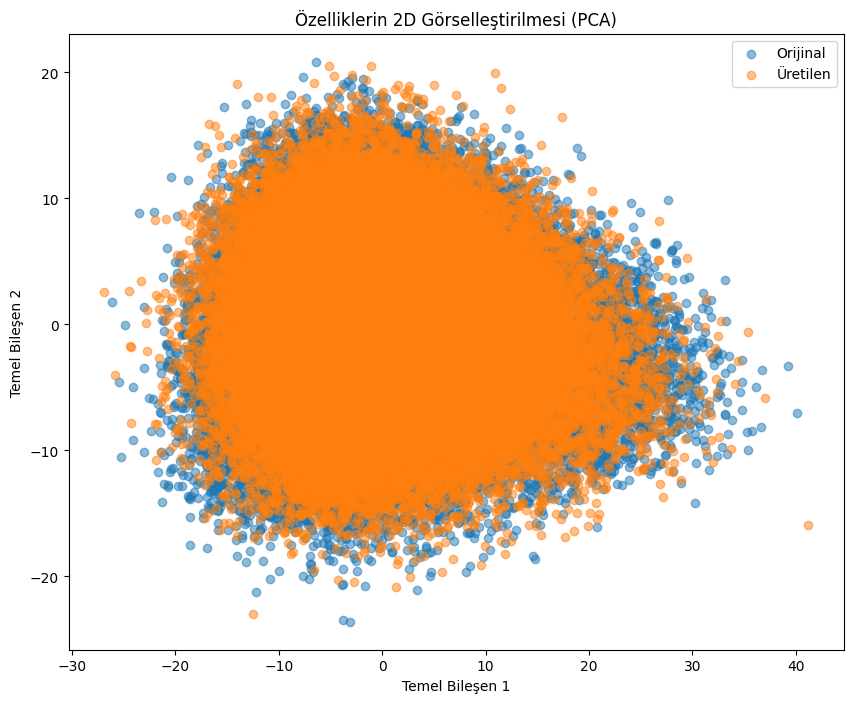

In [25]:
visualize_features(np_original_features, np_generated_features)